colorization_deploy_v2.prototxt already exists at /var/folders/nk/hgf7_brn39q9t4srskbh3vjr0000gn/T/colorization_deploy_v2.prototxt
colorization_release_v2.caffemodel already exists at /var/folders/nk/hgf7_brn39q9t4srskbh3vjr0000gn/T/colorization_release_v2.caffemodel
pts_in_hull.npy already exists at /var/folders/nk/hgf7_brn39q9t4srskbh3vjr0000gn/T/pts_in_hull.npy


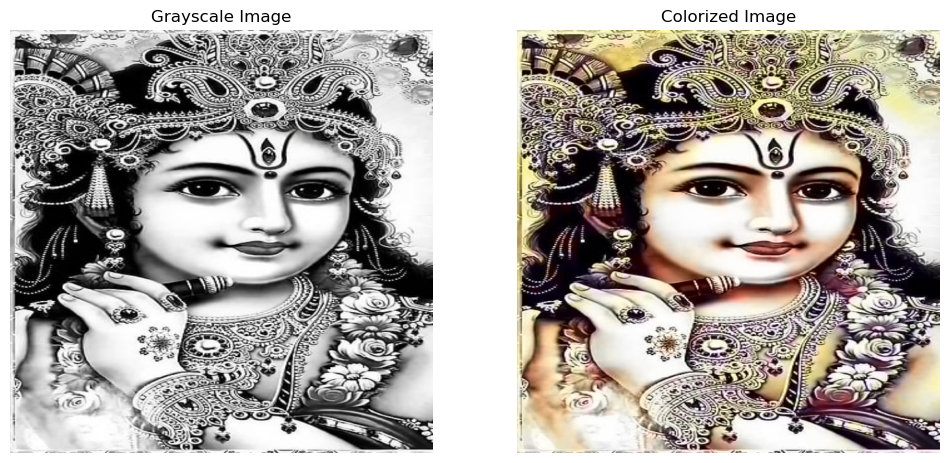

In [2]:
import numpy as np
import cv2
from cv2 import dnn
import urllib.request
import os
import tempfile
import matplotlib.pyplot as plt

# --------Model URLs from Richard Zhang's colorization project-------- #
proto_url = 'https://raw.githubusercontent.com/richzhang/colorization/caffe/colorization/models/colorization_deploy_v2.prototxt'
model_url = 'https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1'
hull_url = 'https://github.com/richzhang/colorization/raw/caffe/colorization/resources/pts_in_hull.npy'
img_path = 'img1.jpg'  # Update this to your image path if not in current directory

# --------Temporary directory for downloaded files-------- #
temp_dir = tempfile.gettempdir()
proto_file = os.path.join(temp_dir, 'colorization_deploy_v2.prototxt')
model_file = os.path.join(temp_dir, 'colorization_release_v2.caffemodel')
hull_pts = os.path.join(temp_dir, 'pts_in_hull.npy')

# --------Download model files if not already present-------- #
def download_file(url, dest):
    if not os.path.exists(dest):
        print(f"Downloading {os.path.basename(dest)} from {url}...")
        urllib.request.urlretrieve(url, dest)
        print(f"Downloaded {os.path.basename(dest)} to {dest}")
    else:
        print(f"{os.path.basename(dest)} already exists at {dest}")

# Download required files
download_file(proto_url, proto_file)
download_file(model_url, model_file)
download_file(hull_url, hull_pts)

# --------Reading the model params-------- #
try:
    net = dnn.readNetFromCaffe(proto_file, model_file)
except cv2.error as e:
    print(f"Error loading model: {e}")
    exit()

try:
    kernel = np.load(hull_pts)
except FileNotFoundError:
    print(f"Error: Could not find {hull_pts}")
    exit()

# --------Add cluster centers as 1x1 convolutions to the model-------- #
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = kernel.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

# --------Reading and preprocessing image-------- #
img = cv2.imread(img_path)
if img is None:
    print(f"Error: Could not load image at {img_path}")
    exit()

scaled = img.astype("float32") / 255.0
lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

# --------Resize the image for the network-------- #
resized = cv2.resize(lab_img, (224, 224))
L = cv2.split(resized)[0]
L -= 50

# --------Predicting the ab channels from the input L channel-------- #
net.setInput(cv2.dnn.blobFromImage(L))
ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))

# --------Take the L channel from the image-------- #
L = cv2.split(lab_img)[0]
colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)

# --------Convert from Lab to BGR-------- #
colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
colorized = np.clip(colorized, 0, 1)
colorized = (255 * colorized).astype("uint8")

# --------Resize images-------- #
img = cv2.resize(img, (640, 640))
colorized = cv2.resize(colorized, (640, 640))

# --------Convert BGR to RGB for matplotlib-------- #
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
colorized_rgb = cv2.cvtColor(colorized, cv2.COLOR_BGR2RGB)

# --------Display images in notebook using matplotlib-------- #
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colorized_rgb)
plt.title('Colorized Image')
plt.axis('off')

plt.show()